## Project 3: fitting ODEs to data and making predictions
The goal of this project is to use simulations of ODEs and fits of ODEs to data to make (and understand) predictions. (60 pts total)

* We will take the following steps.
* For a Nar strain plot the metabolite dynamics in time.
* Fit the yield ($\gamma_A$) from the OD measurements via regression
* Run sims of the ODE at different values of the other parameters ($r_A$) to see what are reasonable values. Use these values to predict other initial conditions.
* Compare our inferred values to the true fits from a more sophisticated algorithm

Communities
* Take fits to two individual strains from the data.
* Plot predicted and measurement metabolite dynamics for a specific pair of strains, compare this plot to individual strain metabolism
* Write down the model for the pairculture
* Understand the features of the pairculture nitrate and nitrite metabolite dynamics in terms of the monoculture traits

First, get the data for monocultures that we are providing.

In [106]:
#Code from fitting single strains
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import denitfit as dn # this is a special set of functions written to deal with this dataset.
from lmfit import Parameters, report_fit
import pickle
from os.path import exists


plt.rc('text', usetex=True)

monocultures = pickle.load(open( "monocultures.pkl", "rb" ))
# extract strain IDs and phenotypes from monocultures object
strain_id = []
phenotype = []
for i in range(0,len(monocultures)):
    strain_id.append(monocultures[i][0].ID) # WE WILL NEED THESE BELOW FOR THE COMMUNITY PREDICTIONS.
    phenotype.append(monocultures[i][0].phen)

In [5]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install latex

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for latex: filename=latex-0.7.0-py3-none-any.whl size=7588 sha256=fdddbcb83dee71bd45b2c98ff82cc7a0538421f7b66a9f13f60d300c860f6e37
  Stored in directory: /Users/kaiden/Library/Caches/pip/wheels/4c/6e/66/29e29480ca5a0c0b2c628bec4e37c21f3eafcd53b0282b48e2
  Created wheel for data: filename=data-0.4-py3-none-any.whl size=7226 sha256=b75ff583786d88a234fde8b33a694afcb47e4c88de4373ebe1686177db5004ae
  Stored in directory: /Users/kaiden/Library/Caches/pip/wheels/0e/90/87/0e55006f5c69af278687927041e334cfb928ab0a7ad9b0c1a3
  Created wheel for shutilwhich: filename=shutilwhich-1.1.0-py3-none-any.whl size=2766 sha256=29aafe4f09074638e920410d47c69b447f097a9f9558b49b96de15dbe639b810
  Stored in directory: /Users/kaiden/Library/Caches/pip/wheels/6d/11/16/61438ffcedd8e5438380547db00e51b4b00cf7fc107714183f
  Created wheel fo

SyntaxError: invalid syntax (549016700.py, line 1)

## The model

Recall the model for a nitrate reducing strain (Nar) takes the following form.

$$ \dot{N} = \frac{r_A \gamma_A N A}{K_A + A} $$
$$ \dot{A} = - \frac{r_A N A}{K_A + A} $$
$$ \dot{I} = \frac{r_A N A}{K_A + A} $$

Where $N$ is biomass (OD), $A$ is nitrate concentration [mM], $r_A$ is a reduction rate [mM / (OD*h)], $\gamma_A$ is a yield $OD/mM$ and $K_A$ is an affinity constant [mM].

### Step 1: for a single Nar strain, let's determine the yield on nitrate. We will work with strain number 59.
Here is how to access the data for strain 58.
the monocultures object is a custom experiment object that contains the data from individual strains grown in isolation (hence 'mono'). 

the data in monocultures can be accessed in the following way:

'monocultures[strain][experiment].DATA'

'strain' is the index of the strain.
'experiment' is the index of a monoculture experiment.  each experiment has different initial conditions (amounts of nitrate, nitrite, and biomass (OD)).
'.DATA' refers to the data for that experiment.  For example, monocultures[strain][experiment].A returns a vector of nitrate measurements, and .I a vector of nitrite measurements, both made a different points in time (.t).  Below you will also use the ".ID" field which is giving a unique identifier to each strain in the dataset.

Here is some example code making plots for the data for on Nar (nitrate only reducing) strain:

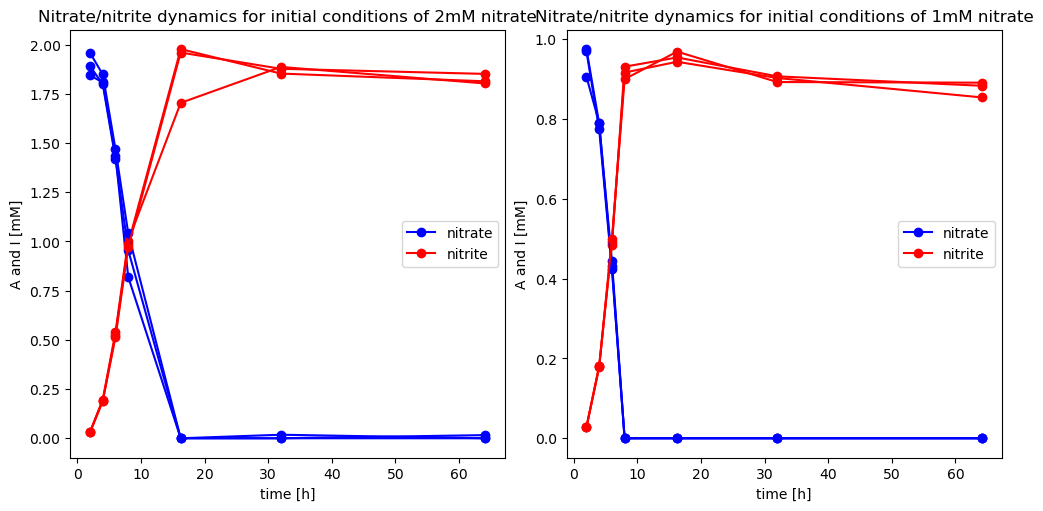

In [111]:
import latex

StrainIdx = 59 # USE THIS GOING FORWARD
fig, axs = plt.subplots(1, 2, figsize=(10, 5), layout = 'constrained')  # 1 row, 2 columns

axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].A[0],'-ob') # each measurement is made in triplicate - replicate 1
axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].I[0],'-or')

axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].A[1],'-ob') # replicate 2
axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].I[1],'-or')

axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].A[2],'-ob') # replicate 3
axs[0].plot(monocultures[StrainIdx][0].t,monocultures[StrainIdx][0].I[2],'-or')


axs[0].legend(['nitrate','nitrite'])
axs[0].set_title('Nitrate/nitrite dynamics for initial conditions of 2mM nitrate')
axs[0].set_xlabel('time [h]')
axs[0].set_ylabel('A and I [mM]')

axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].A[0],'-ob') # each measurement is made in triplicate - replicate 1
axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].I[0],'-or')

axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].A[1],'-ob') # replicate 2
axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].I[1],'-or')

axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].A[2],'-ob') # replicate 3
axs[1].plot(monocultures[StrainIdx][1].t,monocultures[StrainIdx][1].I[2],'-or')


axs[1].legend(['nitrate','nitrite'])
axs[1].set_title('Nitrate/nitrite dynamics for initial conditions of 1mM nitrate')
axs[1].set_xlabel('time [h]')
axs[1].set_ylabel('A and I [mM]')
plt.show()

In [112]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update(plt.rcParamsDefault)

**Question 1:** (6 pts) Estimate $\gamma_A$ via a regression. Remember that $\gamma_A$ has units of OD/mM. And the first two experiments are with 2mM and 1mM initial nitrate concentration. For each of these two experiments make a plot of the CHANGE in OD from start to end vs the amount of nitrate consumed from start to end. In the process of making this plot create a numpy array that has as entries the nitrate consumed and the change in OD.  You should have six such entries, three for each of the replicates.

Note: monocultures[StrainIdx][0].N0 and monocultures[StrainIdx][0].Nend are the OD at the beginning and the end of the growth cycle.

[0.01097785 0.01263227 0.01263227 0.01345949]


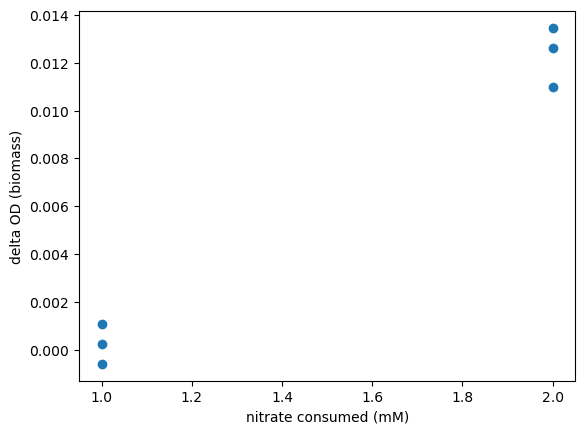

In [120]:
# data1 = [[monocultures[StrainIdx][0].A[0], monocultures[StrainIdx][0].A[-1]],[[monocultures[StrainIdx][0].N0] * 6, monocultures[StrainIdx][0].Nend]]
# print(data1[1][0])
# print(data1[1][1])
# print(data1)

# data2 = [[monocultures[StrainIdx][1].A[0], monocultures[StrainIdx][1].A[-1]],[monocultures[StrainIdx][1].N0, monocultures[StrainIdx][1].Nend]]
# print(data2)

# data1concat = [np.concatenate((data1[0][0],data1[0][1])), np.concatenate((data1[1][0],data1[1][1]))]
# print(data1concat)

#print(monocultures[StrainIdx][0].Nend)
#print(monocultures[StrainIdx][0].N0)
print((monocultures[StrainIdx][0].Nend - monocultures[StrainIdx][0].N0))


exp1vals = np.delete((monocultures[StrainIdx][0].Nend - monocultures[StrainIdx][0].N0), 1)
expnitrate = [2, 2, 2, 1, 1, 1]

exp2vals = np.delete((monocultures[StrainIdx][1].Nend - monocultures[StrainIdx][1].N0), 0)
# print(exp1vals)
# print(exp2vals)
expOD = np.concatenate((exp1vals, exp2vals))

# print(expnitrate)
#print(expOD)

plt.figure()
plt.scatter(expnitrate, expOD)
plt.xlabel('nitrate consumed (mM)')
plt.ylabel('delta OD (biomass)')
plt.show()

**Question 2** (4 pts) Now fit a line to to the matrix you just constructed with the amount of nitrate consumed on the x-axis and the change in OD on the y-axis. The slope of that line is $\gamma_A$, what value do you get?

In [117]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression().fit(np.array(expnitrate).reshape(-1,1), np.array(expOD).reshape(-1,1))

coef = reg.coef_
inter = reg.intercept_
print('predicted gammaA = ' + str(coef))



predicted gammaA = [[0.01213246]]


## Step 2: Using your inferred value of $\gamma_A$ simulate the model for different values of $r_A$.

**Question 3** (10 pts) Write a piece of code that simulates the ODEs written above for the Nar strain using fixed values of $gamma_A$, $r_A$, $K_A$ and some initial conditions.  My recommendation is that you can do one of two things: (1) modify the code from HW4 which is identical but more complex (multiple strains and resources) or (2) use GPT to generate the code and double check that it is getting it right.  In the latter case, I suggest you look carefully at the output! 

## The model

Recall the model for a nitrate reducing strain (Nar) takes the following form.

$$ \dot{N} = \frac{r_A \gamma_A N A}{K_A + A} $$
$$ \dot{A} = - \frac{r_A N A}{K_A + A} $$
$$ \dot{I} = \frac{r_A N A}{K_A + A} $$

Where $N$ is biomass (OD), $A$ is nitrate concentration [mM], $r_A$ is a reduction rate [mM / (OD*h)], $\gamma_A$ is a yield $OD/mM$ and $K_A$ is an affinity constant [mM].

In [118]:
from scipy.integrate import odeint

def rhs(L, t, gamma, rA, Ka):
    N, A, I = L
    dNdt = (rA * gamma * N * A) / (Ka + A)
    dAdt = -(rA * N * A) / (Ka + A)
    dIdt = (rA * N * A) / (Ka + A)
    return dNdt, dAdt, dIdt

def CRM(initials, t, gamma, rA, Ka):
    sol = odeint(rhs, initials, t, args=(gamma, rA, Ka))
    return sol

# #reference maybe
# def F(y,t,p,n_species,n_resources):
#     #ODE RHS
#     Fout = np.zeros(n_species+n_resources)
#     for i in range(n_species):
#         for j in range(n_resources):
#             Fout[i]  = Fout[i]+species_abs(p, y, i, j, n_species)
#     for j in range(n_resources):
#         for i in range(n_species):
#             Fout[n_species+j] = Fout[n_species+j]+resource_concs(p, y, i, j, n_species)
#     return Fout

# def species_abs(p,y,species_idx):
#     r     = p[species_idx, r_idx, 0]
#     gam   = p[species_idx, r_idx, 1]
#     K     = p[species_idx, r_idx, 2]
#     x     = y[species_idx]
#     R     = y[n_species+r_idx]
#     return gam*r*x*R/(K + R) 

# def resource_concs(p,y,species_idx,r_idx,n_species, i_idx):
#     r     = p[species_idx, r_idx, 0]
#     gam   = p[species_idx, r_idx, 1]
#     K     = p[species_idx, r_idx, 2]
#     x     = y[species_idx]
#     R     = y[n_species+r_idx]
#     return -1*r*x*R/(K + R) 

**Question 4** (4 pts) Now take your code from the previous question and put in reasonable values for the parameters. Remember that we assume that $K_A << A$, we have an estimate for $\gamma_A$ and you'll need to provide a plausible guess for $r_A$.  One way to do this is look at the plots above and think about the timescale over which this strain consumes the nitrate. Test whether or not your parameters are reasonable by plotting the results of the simulation on the same axes as the data.  Don't forget to set the initial conditions of your simulation to match those of your experiment! (N0 and A0).

**Report the value of $r_A$ that you think best fits the nitrate and nitrite dynamics for the 2mM nitrate initial condition**

rA is a reduction rate [mM / (OD*h)
over 15h, 2 mM is taken up, detaOD is about 0.12, so about 2 / (0.012 * 15) = 11.1 is a rough estimate


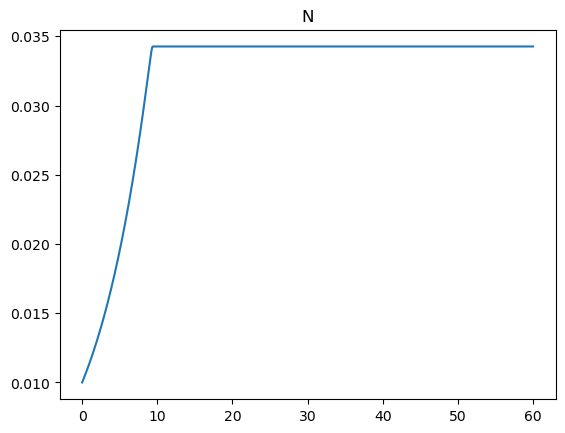

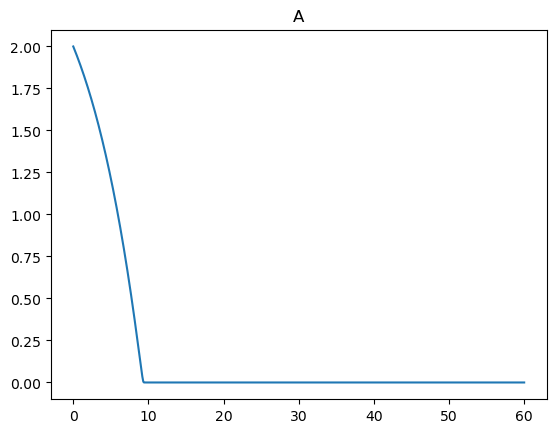

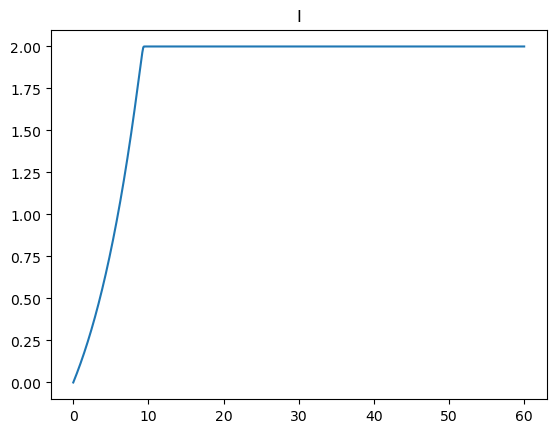

In [127]:
Ka = 0.01
gamma = 0.01213246
print('rA is a reduction rate [mM / (OD*h)')
print('over 15h, 2 mM is taken up, detaOD is about 0.12, so about 2 / (0.012 * 15) = 11.1 is a rough estimate')
rA = 11.1

initials = [0.01, 2, 0]
t_vec = np.linspace(0, 60, 1000)

plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,0])
plt.title('N')
plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,1])
plt.title('A')
plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,2])
plt.title('I')
plt.show()

**Question 5** (4 pts) Now you have an opportunity to perform a sanity check on your inference above. Take the values of the parameters you chose for the simulation above that you compared to the 2mM initial conditions and simulate the dynamics for the 1mM nitrate initial conditions (experiment index 1, see plotting code above).  Does it look like these parameters also work for this initial condition?  Nice experiment right? :)

The parameters from the 2mM also seem to work well for predicting the dynamics of nitrate and nitrite, as the simulations match experimental data of nitrite/nitrate dynamics for 1mM starting nitrate well. 

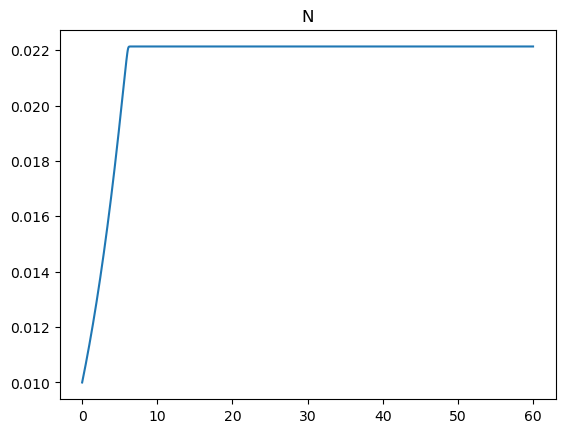

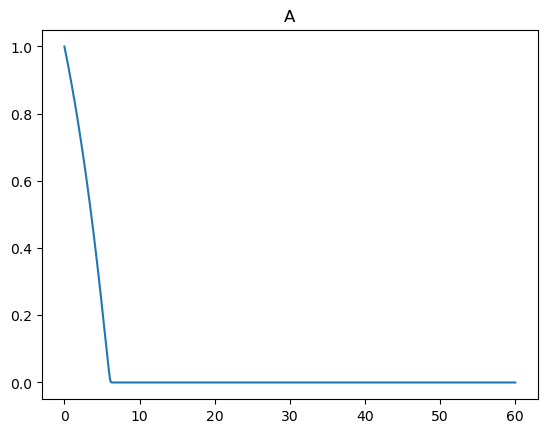

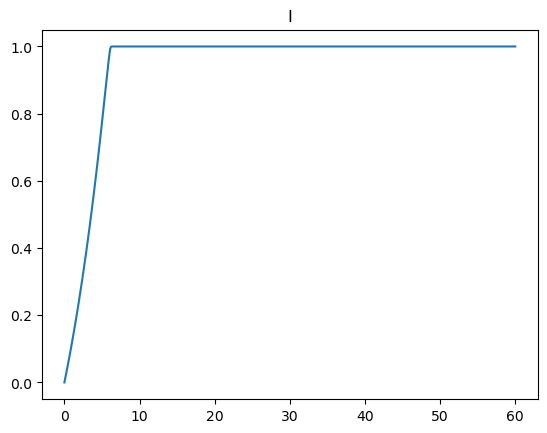

In [128]:
Ka = 0.01
gamma = 0.01213246
rA = 11.1

initials = [0.01, 1, 0]
t_vec = np.linspace(0, 60, 1000)

plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,0])
plt.title('N')
plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,1])
plt.title('A')
plt.figure()
plt.plot(t_vec, CRM(initials, t_vec, gamma, rA, Ka)[:,2])
plt.title('I')
plt.show()

**Question 6** (6 pts) How good was your inference? Use our code to infer the same parameters ($\gamma_A$ and $r_A$ for the same strain) and compare. Report your inferred values above along with those inferred by this code.  Use our custom code to do this inference procedure again in a more sophisticated way. The guts of this code are quite complex and beyond what would be useful to delve into, but briefly, we do a global fit, where all data from all initial conditions are fit to a single set of parameters at once. We then minimize the global root-mean-squared error between the model and the data using Gradient Descent. Having you implement this algorithm on this data would be time consuming, so here we will simply provide the code to do this.  Here is an example of how this is done.  The variable "results" contains the information you need.

In [130]:
import denitfit as dn
i = StrainIdx # pick out the same strain you used above!
params = Parameters()
#for i in range(4):                                                                                                                                                                                            
if monocultures[i][0].phen == 'Nar/Nir':
    params.add('rA', value=10.0, min=0, max=30,vary=True,brute_step=5)
    params.add('rI', value=10.0, min=0, max=25,vary=True,brute_step=5)
elif monocultures[i][0].phen == 'Nar': # DETERMINE WHICH RATES TO FIT FOR NAR STRAINS
    params.add('rA', value=10.0, min=0, max=30,vary=True,brute_step=5)
    params.add('rI', value=0.0, min=0, max=25,vary=False)
elif monocultures[i][0].phen == 'Nir': # DETERMINE WHICH RATES TO FIT FOR NIR STRAINS
    params.add('rA', value=0.0, min=0, max=30,vary=False)
    params.add('rI', value=10.0, min=0, max=25,vary=True,brute_step=5)
                                                                                                                                                 
#Fit yield parameters                                                                                                                                                                                          
gamA,gamI,gam_se,r2 = dn.fitYields(monocultures[i]) #fits the gammas to find the best result across initial conditions.

# it is possible to get yields that are negative, which is not biologically realistic, so set these to zero.
if gamA<0:
    gamA = 0
if gamI<0:
    gamI = 0
if gam_se[0,0]<0:
    gamA = 0
if gam_se[1,0]<0:
    gamI = 0

#Fit rate parameters                                                                       
params.add('kA', value=1e-2, min=1e-3, max=1e1,vary=False) #fix affinity parameters as in paper. can also allow these to vary
params.add('kI', value=1e-2, min=1e-3, max=1e1,vary=False)
params.add('gamA', value=gamA, min=0, max=0.04,vary=False)
params.add('gamI', value=gamI, min=0, max=0.04,vary=False)
result = dn.fitRates(params,monocultures[i]) # THIS LINE FITS THE RATES (RA AND RI AS RELEVANT)

result.params.pretty_print()
print('Global fitter estimates vs my estimates')
print('Global fitter | kA = 0.01      vs Me | kA = 0.01')
print('Global fitter | gamA = 0.08272 vs Me | gamA = 0.01213')
print('Global fitter | rA = 11.3      vs Me | rA = 11.1')
print('The values seem to align pretty well, with rA being especially satisfying. kA being dead on is just a lucky guess though')

Name     Value      Min      Max   Stderr     Vary     Expr Brute_Step
gamA  0.008272        0     0.04        0    False     None     None
gamI         0        0     0.04        0    False     None     None
kA        0.01    0.001       10        0    False     None     None
kI        0.01    0.001       10        0    False     None     None
rA        11.3        0       30   0.1536     True     None        5
rI           0        0       25        0    False     None     None
Global fitter estimates vs my estimates
Global fitter | kA = 0.01      vs Me | kA = 0.01
Global fitter | gamA = 0.08272 vs Me | gamA = 0.01213
Global fitter | rA = 11.3      vs Me | rA = 11.1
The values seem to align pretty well, with rA being especially satisfying. kA being dead on is just a lucky guess though


### STEP 3: predicting metabolism in communities
The last step is to use these models to make predictions in communities. To do this we take the model fit to monoculture data (as we did above) and we simulate the nitrate and nitrite dynamics in co-culture at a fixed starting OD for both strains.  We then compare this prediction to data and ask if it worked or not. Here we will use our custom code to make these comparisons and then interrogate the fits computationally.  First we will need some infrastructure.

**Prefit monocultures** Rather than performing fits on all of the monocultures we will load a set of parameters inferred for all of the monocultures in the entire dataset and some code that plots these data. (Use the code below for Question 7). Note for all of these plots nitrate (A) is in BLUE and nitrite (I) is in RED.

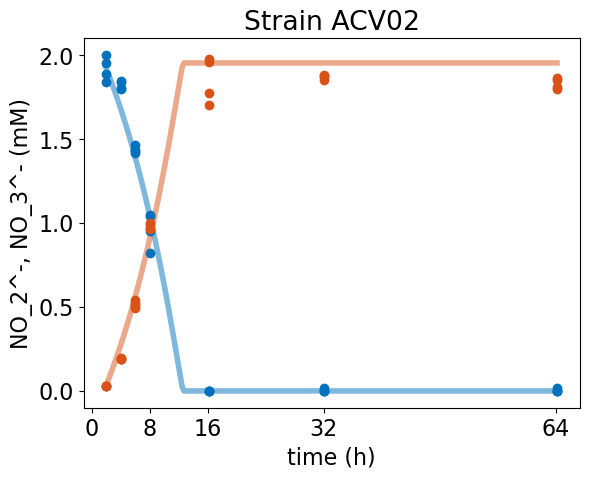

In [85]:
pfit = np.load('pfit.npz')['arr_0']
np.shape(pfit)
# each column of pfit is a different strain, the rows are (in order): rA, rI, kA, kI, gamA, gamI.

# EXAMPLE MONOCULTURE PLOTTING CODE.
StrainIdx = 59
dn.plotDenitFit(pfit[:,StrainIdx,:].T, monocultures[StrainIdx][0]) #plot for the first initial condition, 
# needs the parameters as the first variable and the data as the second variable.
plt.title('Strain ' + monocultures[StrainIdx][0].ID)
plt.show()

**Data for paircultures** Next we'll provide the data for paircultures.  For the purpose of this exercise we will focus on pairculture index 27 which is the pairculture experiment between two strains with IDs ENS09 and PAR01.  The code below takes the pairculture data and plots the **predicted dynamics** from the monoculture data.  Just to be clear, what this means is that the monoculture fits were used to infer model parameters for two strains in separate experiments. The parameters from these fits were then used to simulate the metabolite dynamics in the pairculture and the code below plots this against the measurements.

11
30


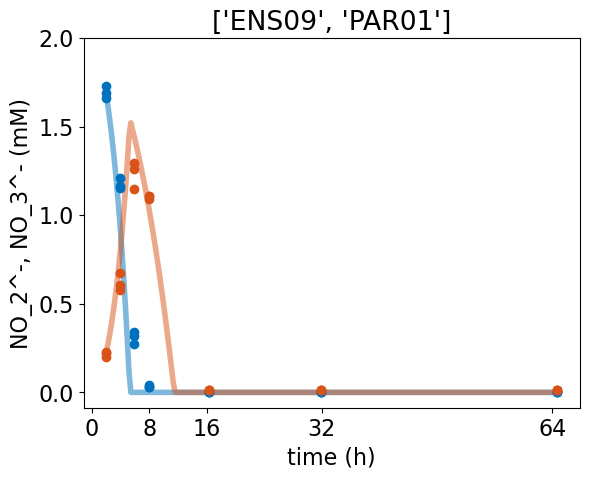

In [5]:
#below is an example that predicts the pair culture at index 1 and compares it to the data. 
paircultures = pickle.load(open( "paircultures.pkl", "rb" ))

i = 27 # DO NOT CHANGE THIS
j = 0 #experiment index; 0 is 2 mM nitrate and 1 is 2 mM nitrite

#grab the parameters that were just fit to monocultures by looking up strain IDs
n_strains = len(paircultures[i][j].ID)
p = [] # this is simply an array we will populate with the right parameters from pfit loaded above.

for k in range(0,n_strains):
    idx = strain_id.index(paircultures[i][j].ID[k]) # this gets the index for each strain ID. THIS COMES FROM THE FIRST CELL ABOVE!
    print(idx) # these are the strain indices for the 
    p.append([pfit[0,idx],pfit[1,idx],1e-2,1e-2,pfit[4,idx],pfit[5,idx]]) 

dn.plotDenitFit(p,paircultures[i][j],n_strains) # this is a custom plotting function that we provided in the denitfit package. 
# Note i is the index of the pairculture and j the index of the experiment.
plt.title(paircultures[i][j].ID);

**Question 7** (2 pts) Keep in mind the plot above uses ONLY the parameters from the monocultures.  Do you think the prediction of metabolite dynamics in the pairculture are good? Why?

They seem to be quite good, given the close alignment of the predicted plots with the experimental data points. This makes sense, since the in the controlled experimental setting, the resource consumption model seems quite accurate.

**Question 8** (4 pts) Use the sample code above to plot the monoculture metabolite dynamics for each of these two strains individually.  Note the code in the previous cell reports the indices of these strains in pfit data, you will need these indices to make these plots.  The question is: what is the phenotype of these two strains? (Nar/Nir; Nar; or Nir)?

Strain ENS09 seems to be NAR/NIR, since it utilizes nitrate, and the lack of nitrite buildup means it can utilize nitrite well.
Strain PAR01 seems to be NAR, since it can reduce nitrate, but nitrite accumultes.

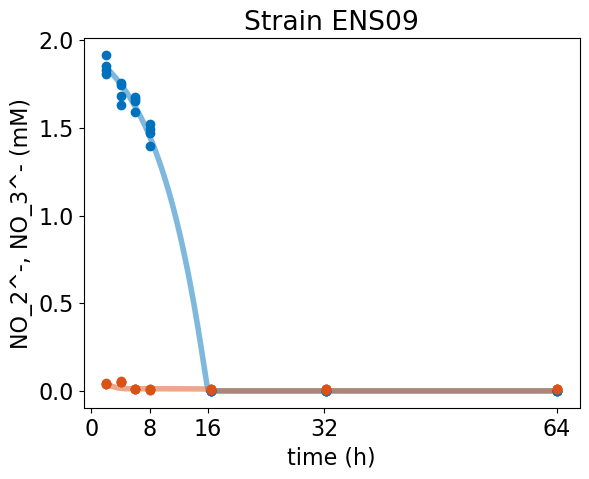

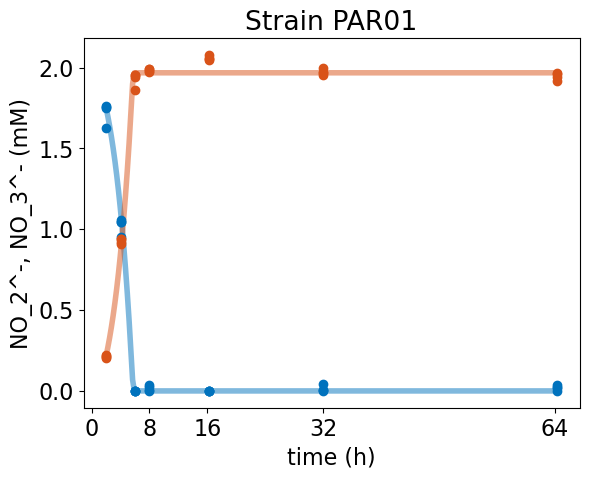

In [78]:
# EXAMPLE MONOCULTURE PLOTTING CODE.
StrainIdx = 11 # ENS09 is a Nar/Nir strain, does both reactions.
dn.plotDenitFit(pfit[:,StrainIdx,:].T, monocultures[StrainIdx][0]) #plot for the first initial condition, THIS IS OUR CUSTOM FUNCTION
# needs the parameters as the first variable and the data as the second variable.
plt.title('Strain ' + monocultures[StrainIdx][0].ID)

plt.figure()
StrainIdx = 30 # PAR01 is a Nar strain, does both reactions.
dn.plotDenitFit(pfit[:,StrainIdx,:].T, monocultures[StrainIdx][0]) #plot for the first initial condition, 
# needs the parameters as the first variable and the data as the second variable.
plt.title('Strain ' + monocultures[StrainIdx][0].ID)
plt.show()

**Question 9** (2 pts) Which strain performs nitrite (I) reduction (utilization)?

ENS09 likely performs nirite utilization

**Question 10** (8 pts) In latex code write down the model for these two strains growing together on nitrate and nitrite.

$$ \dot{N_{s1}} = \frac{r_{A, s1} \gamma_{A, s1} N_{s1} A}{K_{A, s1} + A} $$
$$ \dot{N_{s2}} = \frac{r_{A, s2} \gamma_{A, s2} N_{s2} A}{K_{A, s2} + A} $$
$$ \dot{A} = - (\frac{r_{A, s1} N_{s1} A}{K_{A, s2} + A} + \frac{r_{A, s2} N_{s2} A}{K_{A, s2} + A}) $$
$$ \dot{I} = \frac{r_{A, s1} N_{s1} A}{K_{A,s1} + A} + \frac{r_{A, s2} N_{s2} A}{K_{A, s2} + A} $$


**Question 11** (8 pts) Given you answers to questions 8 to 10 consider the following question. Why does nitrite accumulate in the pairculture experiment before being consumed?  e.g. why is there a spike in the red curve in the pairculture plot above for ENS09 and PAR01?  Why does it accumulate?

Nitrite is being produced by PAR01 faster than ENS09 can consume both the nitrite it produces and PAR01 produces, causing nitrite to accumulate, until nitrate has been depleted and no more nitrite forms. 

**Question 12** (6 pts) Which parameters would you have to CHANGE to get the accumulation of nitrite in the pairculture to go away?

You could increase the uptake of nitrite in the Nar/Nir strain, which would be represented by increaseing the variable rI. 

**EXTRA CREDIT** (10 pts)  the code above to show that your answer to question 11 is correct by changing the parameters and re-running the simulation.

When rI is changed to 30, nirite fails to spike up.

11
30
[[array([4.05998578]), array([7.34055154]), 0.01, 0.01, array([0.01568888]), array([0.02032355])], [array([18.04938928]), array([0.]), 0.01, 0.01, array([0.02161245]), array([0.])]]
[30]
[[array([4.05998578]), array([30]), 0.01, 0.01, array([0.01568888]), array([0.02032355])], [array([18.04938928]), array([0.]), 0.01, 0.01, array([0.02161245]), array([0.])]]


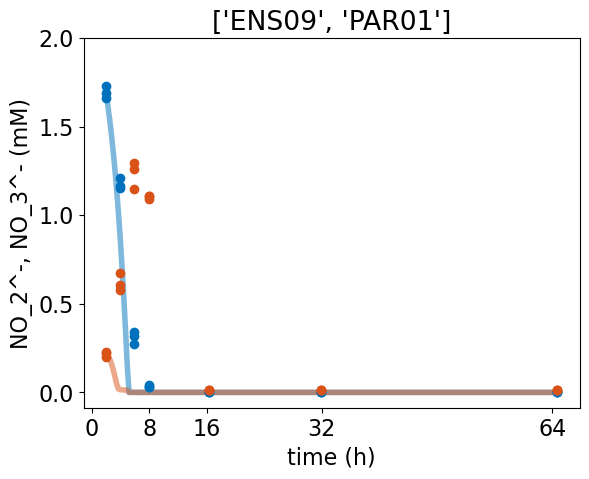

In [102]:
#below is an example that predicts the pair culture at index 1 and compares it to the data. 
paircultures = pickle.load(open( "paircultures.pkl", "rb" ))

i = 27 # DO NOT CHANGE THIS
j = 0 #experiment index; 0 is 2 mM nitrate and 1 is 2 mM nitrite

#grab the parameters that were just fit to monocultures by looking up strain IDs
n_strains = len(paircultures[i][j].ID)
p = [] # this is simply an array we will populate with the right parameters from pfit loaded above.

for k in range(0,n_strains):
    idx = strain_id.index(paircultures[i][j].ID[k]) # this gets the index for each strain ID. THIS COMES FROM THE FIRST CELL ABOVE!
    print(idx) # these are the strain indices for the 
    p.append([pfit[0,idx],pfit[1,idx],1e-2,1e-2,pfit[4,idx],pfit[5,idx]]) 
print(p)
#rI is row 2
#idx is index 11
newrI = np.array([30])
print(newrI)
p[0][1] = newrI
print(p)

dn.plotDenitFit(p,paircultures[i][j],n_strains) # this is a custom plotting function that we provided in the denitfit package. 
# Note i is the index of the pairculture and j the index of the experiment.
plt.title(paircultures[i][j].ID);
plt.show()